## Model comparison using DS score
#### Jianfeng
#### 04/08/2024

In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from decimal import Decimal
from scipy import stats
from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
# initial settings
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# name difference
def find_allen_name(gtex_region):
    if gtex_region=='Cerebellar_Hemisphere':
        allen_name = 'Cerebellum'
    elif gtex_region=='Frontal_Cortex_BA9':
        allen_name = 'Cortex'
    else:
        allen_name = gtex_region
        
    return allen_name

# settings
all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']

# path
allen_data_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/allen/'
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'

GeneExpression_allen_dict = {}
# iterate over all 6 subjects
for i in range(len(all_ids)):
    donor = all_ids[i]
    file_name = save_path + "normalized_expr_" + donor + ".csv"
    normalized_mat = pd.read_csv(file_name, header = 0)
    normalized_mat = normalized_mat.set_index('gene_symbol')
    GeneExpression_allen_dict[donor] = normalized_mat
    
    
ontology_path = allen_data_path + 'normalized_microarray_donor' + '9861' + '/Ontology.csv'
ontology = pd.read_csv(ontology_path, header = 0)
# From the ontology file, find the sub-regions in allen under gtex region
gtex_map_path = allen_data_path + "map_gtex_structure.txt"
gTex_map_dict = {}
print("Total number of regions in allen ontology:", ontology.shape[0])
for i in open(gtex_map_path):
    i = i.strip().split("\t")
    gtex_region = i[0].strip()
    allen_region = i[1].strip()
    if((allen_region == "none?") | (allen_region == 'pituitary body')):
        continue
    covered_allen_region = ontology.loc[(ontology['name']==allen_region) | ontology['structure_id_path'].str.startswith(ontology.loc[ontology['name']==allen_region, 'structure_id_path'].values[0]), 'id']
    gTex_map_dict[gtex_region] = covered_allen_region.tolist()
    print(gtex_region, "-->", allen_region, ";  number of regions in allen:", len(covered_allen_region))
print("\n")
    
    
intersected_region = GeneExpression_allen_dict['9861'].columns.tolist()
used_intersected_region_dict = {}
# unseen_intersected_region_dict = {}
for gtex_region, covered_allen_region in gTex_map_dict.items():
    used_region_list = [x for x in intersected_region if int(x) in covered_allen_region]
    used_intersected_region_dict[gtex_region] = used_region_list
    print(gtex_region, " # regions expired:", len(used_region_list))
num_used_region = sum(len(value) for value in used_intersected_region_dict.values())
print("Total number of intersected region between allen and gtex:", len(intersected_region))
print("Total number of used allen region for generating regions for gtex:", num_used_region)
print("Total number of unseen allen regions when generating regions for gtex:", len(intersected_region)-num_used_region)
print("\n")


# read the summarized allen data (in gtex format) into a dictionary
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'
# find the file and read it into a dictionary
summarized_gtex_dict = {}
for file_name in os.listdir(save_path):
    if file_name.endswith('-gtex.txt'):
        key = file_name.split('-gtex.txt')[0]
        file_path = os.path.join(save_path, file_name)
        mat = pd.read_csv(file_path, sep='\t', index_col=0)
        #mat = mat.iloc[:-1]
        # Store the dataframe in the dictionary with the key
        summarized_gtex_dict[key] = mat
        

# Load gtex data
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/12052023/'
gt = pd.read_csv(data_dir+"new_normed_gtex_gtex_allen_gene.txt", low_memory=False, index_col=0, sep="\t")

# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_count_dict = {}
for s in sample_subject_list:
    if s in subject_count_dict:
        subject_count_dict[s] = subject_count_dict[s] + 1
    else:
        subject_count_dict[s] = 1
# build a dictionary to count the freq of each region
sample_region_list = gt.loc['region'].tolist()
region_count_dict = {}
for s in sample_region_list:
    if s in region_count_dict:
        region_count_dict[s] = region_count_dict[s] + 1
    else:
        region_count_dict[s] = 1  
# find the subjects that have all 10 regions
pick_subject = [s for s, c in subject_count_dict.items() if c==10]
# build a dictionary for exp data for each subject in gtex who has all 10 brain regions
exp_gtex_dict = {}
for subject in pick_subject:
    submat = gt[gt.columns[gt.iloc[1]==subject]]
    submat.columns = submat.loc['region',:]
    submat = submat.iloc[2:,]
    submat.index.names = ['gene_id']
    submat = submat.sort_values(by=['gene_id'])
    submat = submat[region_pick]
    # And also, transform the dataframe in gtex from strings to numbers
    submat = submat.apply(pd.to_numeric, errors='ignore')
    # Take the average if more than 1 sample have the same gene names
    submat = submat.groupby(submat.index).mean()
    exp_gtex_dict[subject] = submat
# find 30 gtex subjects
sub_all_ids = list(exp_gtex_dict.keys())
    
    
# gene_module = pd.read_csv(allen_data_path+'41593_2015_BFnn4171_MOESM97_ESM.csv')
allen_gene_list = GeneExpression_allen_dict['9861'].index
gtex_gene_list = exp_gtex_dict['GTEX-N7MT'].index
overlapped_gene_list = [x for x in gtex_gene_list if x in allen_gene_list]  # 15044 genes here
# allen subject gene expression profile on the overlapped genes
exp_allen_dict = {}
for key, mat in GeneExpression_allen_dict.items():
    exp_allen_dict[key] = mat.loc[overlapped_gene_list]
# summarized gtex info for allen subjects on the overlapped genes
summ_gtex_info = {}
for key, mat in summarized_gtex_dict.items():
    summ_gtex_info[key] = mat.loc[overlapped_gene_list]
# rename the Cerebellum to Cerebellar_Hemisphere and Cortex to Frontal_Cortex_BA for allen people
for subject, mat in summ_gtex_info.items():
    mat.columns = exp_gtex_dict['GTEX-N7MT'].columns


# gene embeddings
g_emb_error = 0.035
g_emb_size = 2 ** 4
g_emb_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/'
g_emb_name = f'allen_gtex_gene_emb_all6subjects_size_{g_emb_size}_pearson_err_{g_emb_error}_intersected103.csv'
# np.savetxt(g_emb_path+g_emb_name, pretrain_g_emb, delimiter=',')
# read the pretrained gene embedding
pretrain_g_emb = np.genfromtxt(g_emb_path+g_emb_name, delimiter=',', dtype=np.float32)
import pickle
# Load the gene names from the file
with open(g_emb_path+g_emb_name+'_genenames.pkl', 'rb') as file:
    gene_emb_names_list = pickle.load(file)
    

# Build the edge list
# From the Ontology find the node relationship list
onto_file_path = 'normalized_microarray_donor10021/Ontology.csv'
onto_file_path = os.path.join(allen_data_path, onto_file_path)
ontology = pd.read_csv(onto_file_path)
ontology_id = ontology.loc[:, ['id', 'parent_structure_id']]
# set the parent node of 4005 to -1
ontology_id.iloc[0,1] = -1
ontology_id['parent_structure_id'] = ontology_id['parent_structure_id'].astype(int)
# View the nodes in a hierarchical way
node_child = [int(x) for x in intersected_region]
all_node = []
for i in range(1,20):
    if i==1:
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
    if len(node_child)==1:
        break
    if i!=1:
        node_parent = []
        for node in node_child:
            pos = ontology_id['id'].index[ontology_id['id']==node]
            # skip if it's already the ancestor
            if len(pos)==0: continue
            parent = ontology_id['parent_structure_id'][pos].values[0]
            node_parent.append(parent)
        node_parent = set(node_parent)
        node_child = [x for x in node_parent]
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
repeated_nodes = [x for y in all_node for x in y]
pick_nodes = set(repeated_nodes)
print(f"There are {len(pick_nodes)} nodes in total")

pick_nodes = [x for x in pick_nodes]
pick_nodes.sort()
# exclude the ancestor node (4005) and the '-1' node
intersected_nodes_child = pick_nodes[2:]
child_nodes_chr = list(exp_allen_dict['9861'].columns)
child_nodes = [int(x) for x in child_nodes_chr]
# append other hyper-level nodes to the pick_nodes
for x in intersected_nodes_child:
    if x not in child_nodes:
        child_nodes.append(x)
# find the parent nodes for the pick_nodes
parent_nodes = []
for x in child_nodes:
    pos = ontology_id['id'].index[ontology_id['id']==x][0]
    parent = ontology_id['parent_structure_id'][pos]
    parent_nodes.append(parent)
    
for _ in range(len(parent_nodes)):
    length = len(parent_nodes)
    for i in range(length):
        cid = child_nodes[i]
        pid = parent_nodes[i]
        if pid!=4005:
            # find how many children this parent node has
            count1 = parent_nodes.count(pid)
            # if this count is more than one, we don't remove this node
            if count1 > 1:
                continue
            # if this parent node only has one child, we remove it
            else:
                # find the position of this parent node in the children node list
                pidx = child_nodes.index(pid)
                # find the grandparent
                ppid = parent_nodes[pidx]
                # remove this parent and directly connect the child to its grandparent
                child_nodes[pidx] = cid
                child_nodes.pop(i)
                parent_nodes.pop(i)
                break
    if len(parent_nodes)==length:
        break
        
# put the leaves at the beginning
initial_nodes_chr = list(exp_allen_dict['9861'].columns)
new_child_nodes = [int(x) for x in initial_nodes_chr]
new_parent_nodes = []
for x in child_nodes:
    if x not in new_child_nodes:
        new_child_nodes.append(x)
for x in new_child_nodes:
    new_parent_nodes.append(parent_nodes[child_nodes.index(x)])

# put all nodes together in order so we can re-assign node id
all_nodes = new_child_nodes.copy()
for x in new_parent_nodes:
    if x not in all_nodes:
        all_nodes.append(x)

# re-index all the nodes and all the dataframe
child_nodes_idx = []
parent_nodes_idx = []
for node in new_child_nodes:
    child_nodes_idx.append(all_nodes.index(node))
for node in new_parent_nodes:
    parent_nodes_idx.append(all_nodes.index(node))


# Model pre-setting
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
keys = list(exp_allen_dict[all_ids[0]].columns)
# other settings
N_gene = len(exp_allen_dict['9861'])
N_node = len(child_nodes_idx)+1
n_node = len(intersected_region)
# define the edge list
# add edges between region nodes
edge_index_1 = [[child_nodes_idx[i], parent_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index_2 = [[parent_nodes_idx[i], child_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index = edge_index_1 + edge_index_2
for i in range(N_node):
    edge_index.append([i, i])
    

# generate the list of 56 unseen allen regions
used_region_list = []
for k, v in used_intersected_region_dict.items():
    used_region_list = used_region_list + v
all_region = list(exp_allen_dict[all_ids[0]].columns)
unseen_region_list = [x for x in all_region if x not in used_region_list]

Total number of regions in allen ontology: 1839
Amygdala --> amygdala ;  number of regions in allen: 135
Anterior_cingulate_cortex_BA24 --> cingulate gyrus, frontal part ;  number of regions in allen: 7
Caudate_basal_ganglia --> caudate nucleus ;  number of regions in allen: 10
Cerebellum --> cerebellum ;  number of regions in allen: 95
Cortex --> frontal lobe ;  number of regions in allen: 87
Hippocampus --> hippocampal formation ;  number of regions in allen: 30
Hypothalamus --> hypothalamus ;  number of regions in allen: 176
Nucleus_accumbens_basal_ganglia --> nucleus accumbens ;  number of regions in allen: 3
Putamen_basal_ganglia --> putamen ;  number of regions in allen: 3
Substantia_nigra --> substantia nigra ;  number of regions in allen: 7


Amygdala  # regions expired: 6
Anterior_cingulate_cortex_BA24  # regions expired: 2
Caudate_basal_ganglia  # regions expired: 3
Cerebellum  # regions expired: 9
Cortex  # regions expired: 14
Hippocampus  # regions expired: 6
Hypothalamus  

### Load allen regions prediction for gtex subjects

In [3]:
# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_region_mat = pd.DataFrame(np.zeros((len(set(sample_subject_list)), len(region_pick)), dtype=int))
subject_region_mat.index = sorted(set(sample_subject_list))
subject_region_mat.columns = region_pick
for i in range(gt.shape[1]):
    region = gt.loc['region'][i]
    subject = gt.loc['subject'][i]
    region_idx = region_pick.index(region)
    subject_idx = subject_region_mat.index.tolist().index(subject)
    subject_region_mat.iloc[subject_idx, region_idx] = 1

# # generate GO model input
go_prediction_dict = {}
# model_set = [[300,0,"NA"], [500,0, "NA"], [300,300,"trainable"], [300,300,"freeze"], 
#              [500,500,"trainable"], [500,500,"freeze"], [300,500,"trainable"], [300,500,"freeze"]]
# model_set = [[300,0,"NA"], [300,500,"trainable"]]
model_set = [[300,500,"trainable"]]
for pars in model_set:
    t_epoch, f_epoch, status = pars
    key = f"{t_epoch}_{f_epoch}_{status}"
    go_prediction_dict[key] = {}
    save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/'
    missing_N = 5
    if f_epoch==0:
        dict_name = f'gtex_allen_region_epoch_{t_epoch}_missing_N_{missing_N}.pickle'
    else:
        dict_name = f'gtex_allen_region_trainable_GNN_af_epoch_{t_epoch}_fepoch_{f_epoch}_missing_N_{missing_N}.pickle'
    # Reading the pickled data from file
    with open(save_dir+dict_name, 'rb') as f:
        go_prediction_dict[key] = pickle.load(f)

# read the allen dataset
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_10_103/Prediction/'
dict_name = f'allen_dataset_dict.pickle'
with open(data_dir+dict_name, 'rb') as f:
    allen_dict = pickle.load(f)

In [4]:
# given a dictionary and a list of subjects, compute DS score
def ds_score_compute_56(dictionary, subjects):
    corr_dict = {}
    for i in range(len(subjects)):
        subject1 = subjects[i]
        mat1 = dictionary[subject1][unseen_region_list]
        for j in range((i+1), len(subjects)):
            subject2 = subjects[j]
            mat2 = dictionary[subject2][unseen_region_list]
            key_name = f"{subject1}_w_{subject2}"
            corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
            corr_dict[key_name] = corr_list
    x = list(zip(*corr_dict.values()))
    ds_score = [sum(z) / len(z) for z in x]
    
    return ds_score

# given a dictionary and a list of subjects, compute DS score
def ds_score_compute_103(dictionary, subjects):
    corr_dict = {}
    for i in range(len(subjects)):
        subject1 = subjects[i]
        mat1 = dictionary[subject1]
        for j in range((i+1), len(subjects)):
            subject2 = subjects[j]
            mat2 = dictionary[subject2]
            key_name = f"{subject1}_w_{subject2}"
            corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
            corr_dict[key_name] = corr_list
    x = list(zip(*corr_dict.values()))
    ds_score = [sum(z) / len(z) for z in x]
    
    return ds_score

### DS score at gene level

In [31]:
allen_ds = ds_score_compute_103(allen_dict, all_ids)
missing_N = 5
t_epoch, f_epoch, status = 300,500,"trainable"
model_name = f"{t_epoch}_{f_epoch}_{status}"
pred_exp_dict = go_prediction_dict[model_name]
include_subjects = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()>=(10-missing_N)]
gtex_ds = ds_score_compute_103(pred_exp_dict, include_subjects)
corr, p = spearmanr(allen_ds, gtex_ds)

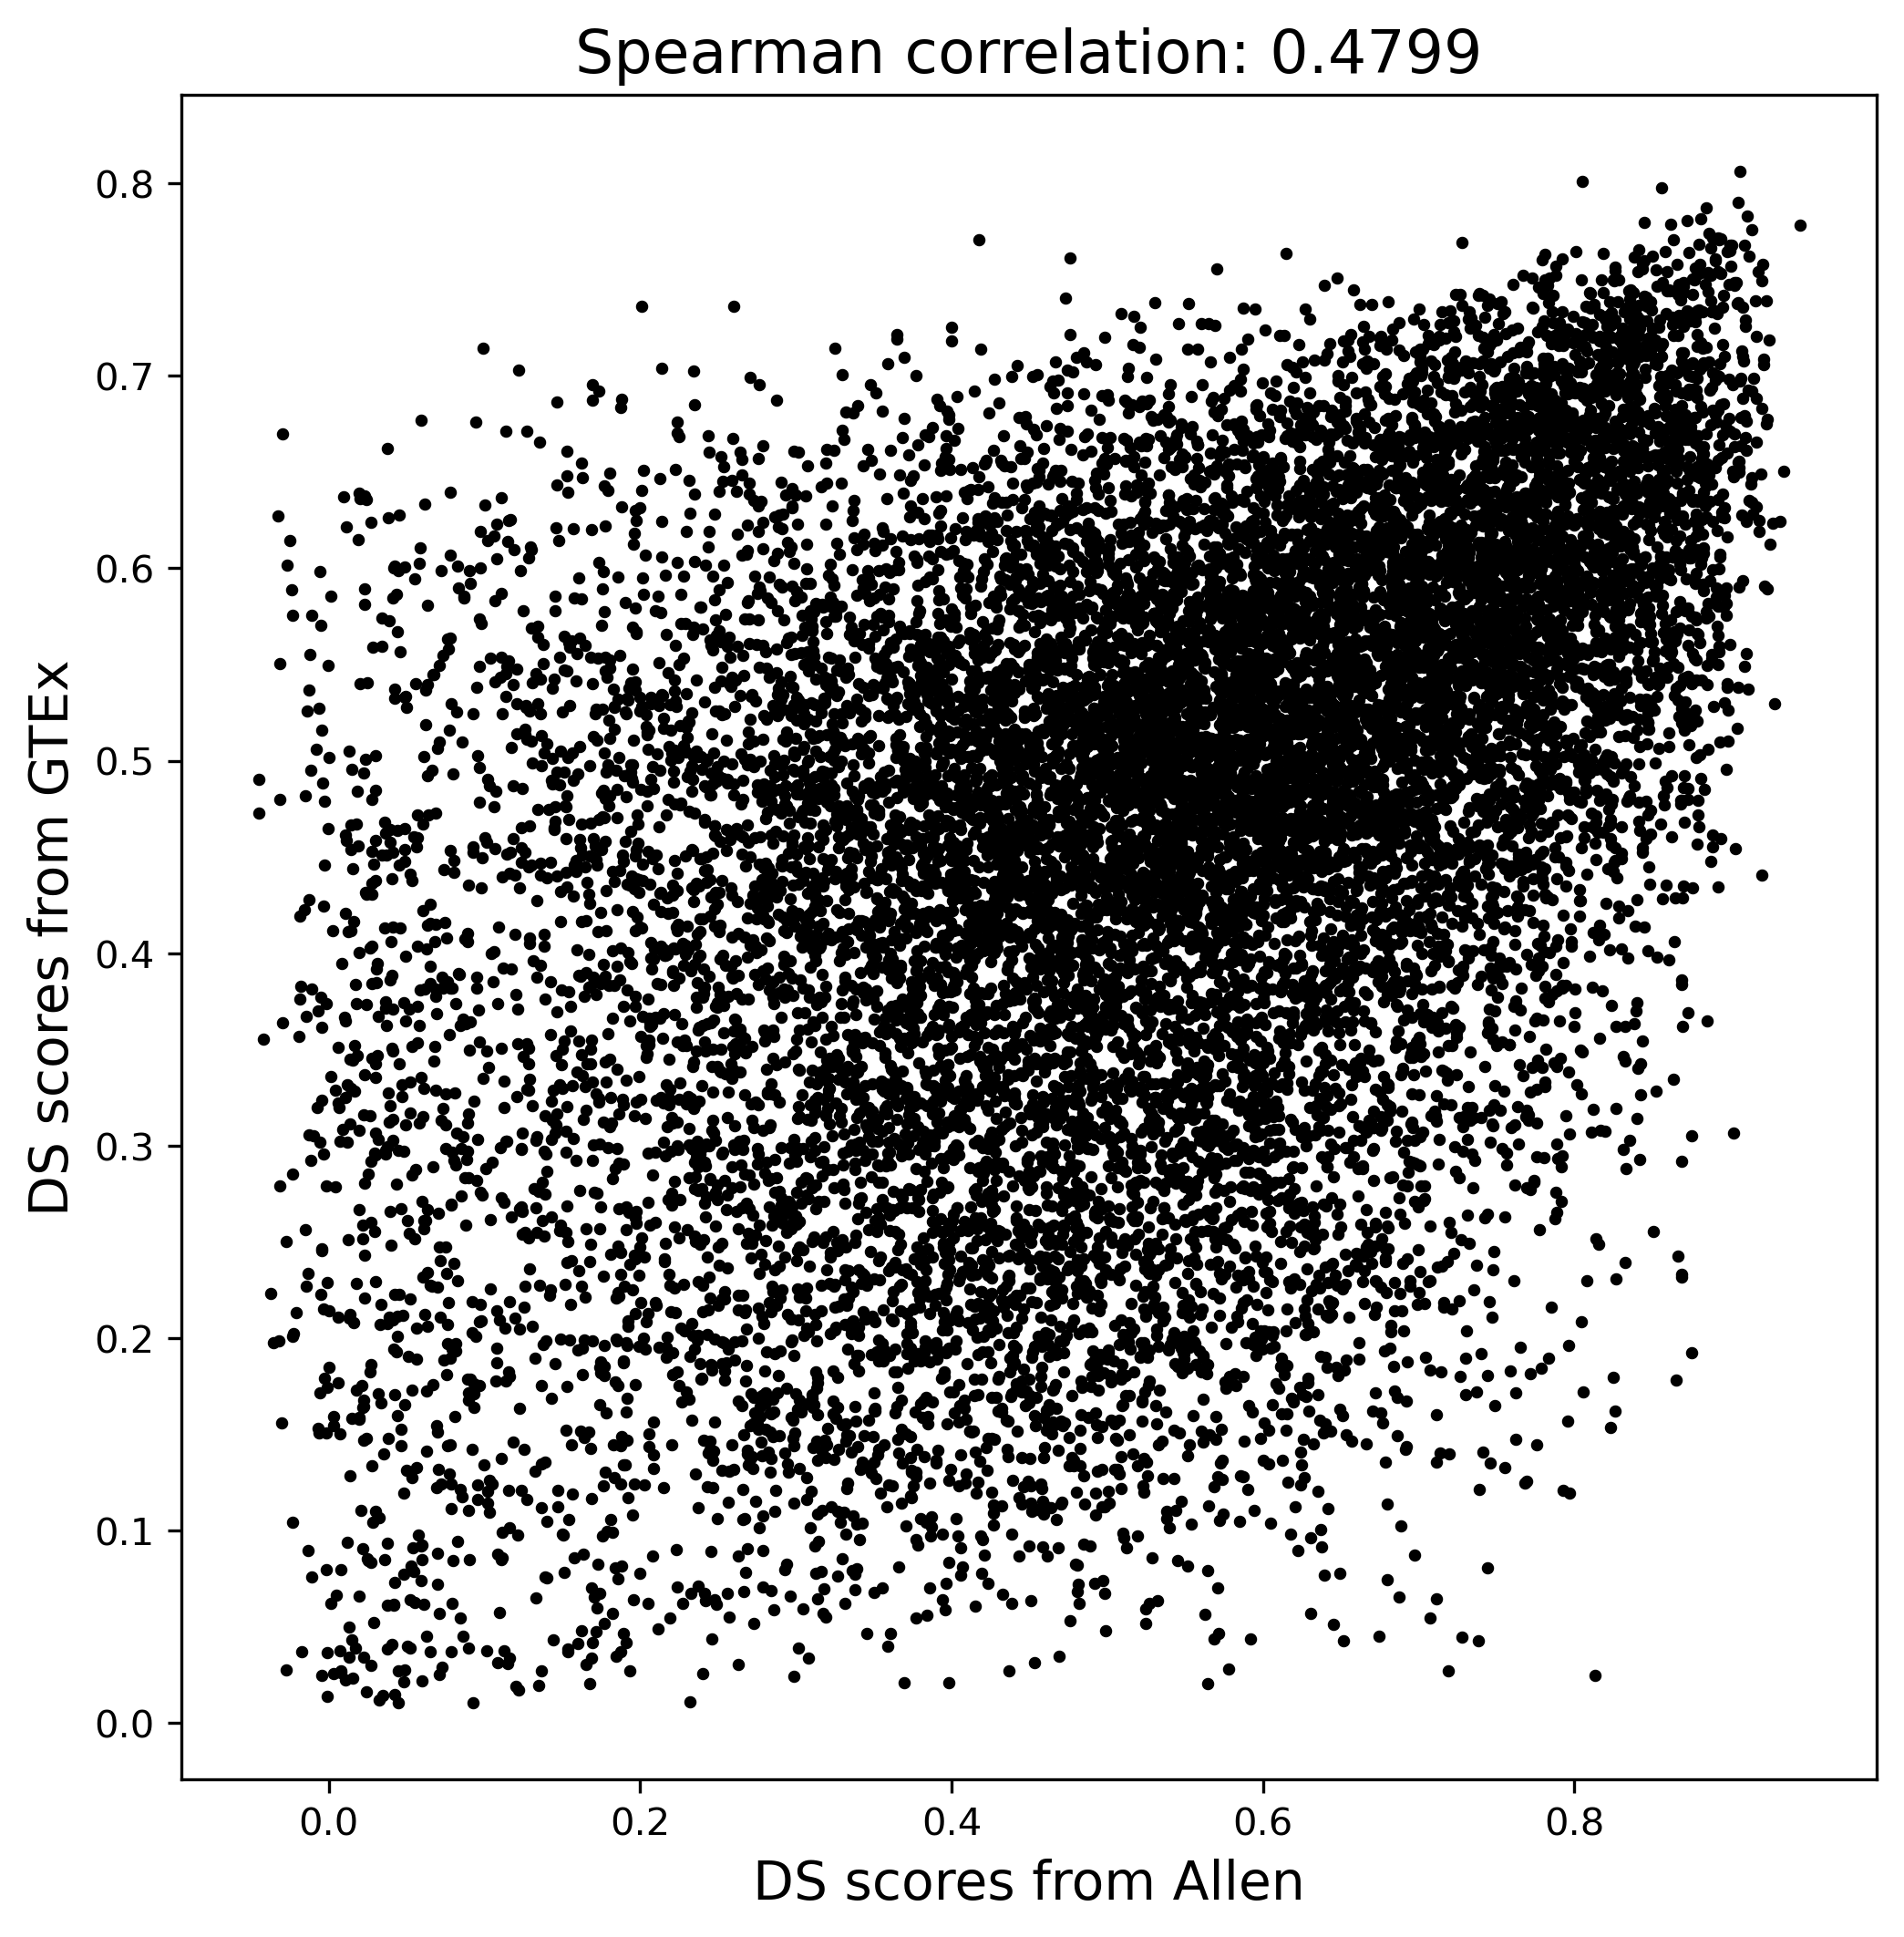

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(allen_ds, gtex_ds, color='black', marker='o', s=5)
# plt.hexbin(allen_ds, gtex_ds, gridsize=30, cmap='Blues')
plt.title(f'Spearman correlation: {corr:.4f}', fontsize=16)
plt.xlabel('DS scores from Allen', fontsize=14)
plt.ylabel('DS scores from GTEx', fontsize=14)
plt.grid(False)

plt.show()

### DS score for a group of GTEx subjects

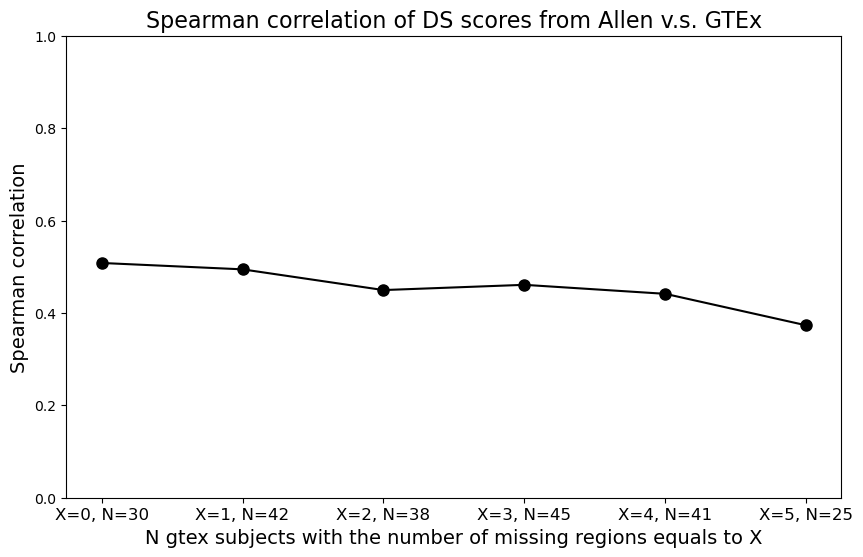

In [ ]:
allen_ds = ds_score_compute_103(allen_dict, all_ids)
N = 6
# Create violin plots
plt.figure(figsize=(10, 6))
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
colors = ['black']
# for each model, plot a curve
for i in range(len(model_set)):
    spear_corr_list = []
    n_subject = []
    t_epoch, f_epoch, status = model_set[i]
    model_name = f"{t_epoch}_{f_epoch}_{status}"
    pred_exp_dict = go_prediction_dict[model_name]
    for missing_N in range(N):
        include_subjects = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()==(10-missing_N)]
        gtex_ds = ds_score_compute_103(pred_exp_dict, include_subjects)
        corr, p = spearmanr(allen_ds, gtex_ds)
        spear_corr_list.append(corr)
        n_subject.append(len(include_subjects))
    # plotting
    # plt.plot([x for x in range(N)], spear_corr_list, marker='o', color=colors[i], linestyle='-', markersize=6, label=model_name)
    plt.plot([x for x in range(N)], spear_corr_list, marker='o', color=colors[i], linestyle='-', markersize=8)
    
# Plot means for second set of violin plots
# plt.title(f'Spearman correlation of allen_ds v.s. gtex_ds across different GO models on 103 regions', fontsize=10)
plt.title(f'Spearman correlation of DS scores from Allen v.s. GTEx', fontsize=16)
# plt.xlabel('N gtex subjects with the number of missing regions equals to X', fontsize=10)
plt.xlabel('N gtex subjects with the number of missing regions equals to X', fontsize=14)
# plt.ylabel('Spearman correlation', fontsize=10)
plt.ylabel('Spearman correlation', fontsize=14)
# plt.xticks(range(N), [f"X={i}, N={n_subject[i]}" for i in range(N)], fontsize=8)
plt.xticks(range(N), [f"X={i}, N={n_subject[i]}" for i in range(N)], fontsize=12)
plt.ylim(0,1)
# plt.legend(fontsize=8)
plt.show()

In [ ]:
# Initialize storage for results
N = 6
results = []

# Loop through each model
for i in range(len(model_set)):
    spear_corr_list = []
    n_subject_list = []
    t_epoch, f_epoch, status = model_set[i]
    model_name = f"{t_epoch}_{f_epoch}_{status}"
    pred_exp_dict = go_prediction_dict[model_name]
    
    # Compute Spearman correlations for different missing region counts
    for missing_N in range(N):
        # Identify subjects with the specified number of missing regions
        include_subjects = [
            s for s in subject_region_mat.index 
            if subject_region_mat.loc[s].sum() == (10 - missing_N)
        ]
        # Compute GTEx DS scores and Spearman correlation
        gtex_ds = ds_score_compute_103(pred_exp_dict, include_subjects)
        corr, _ = spearmanr(allen_ds, gtex_ds)
        
        # Store results
        spear_corr_list.append(corr)
        n_subject_list.append(len(include_subjects))
    
    # Append results for the current model
    results.append({
        'model_name': model_name,
        'spear_corr_list': spear_corr_list,
        'n_subject_list': n_subject_list
    })


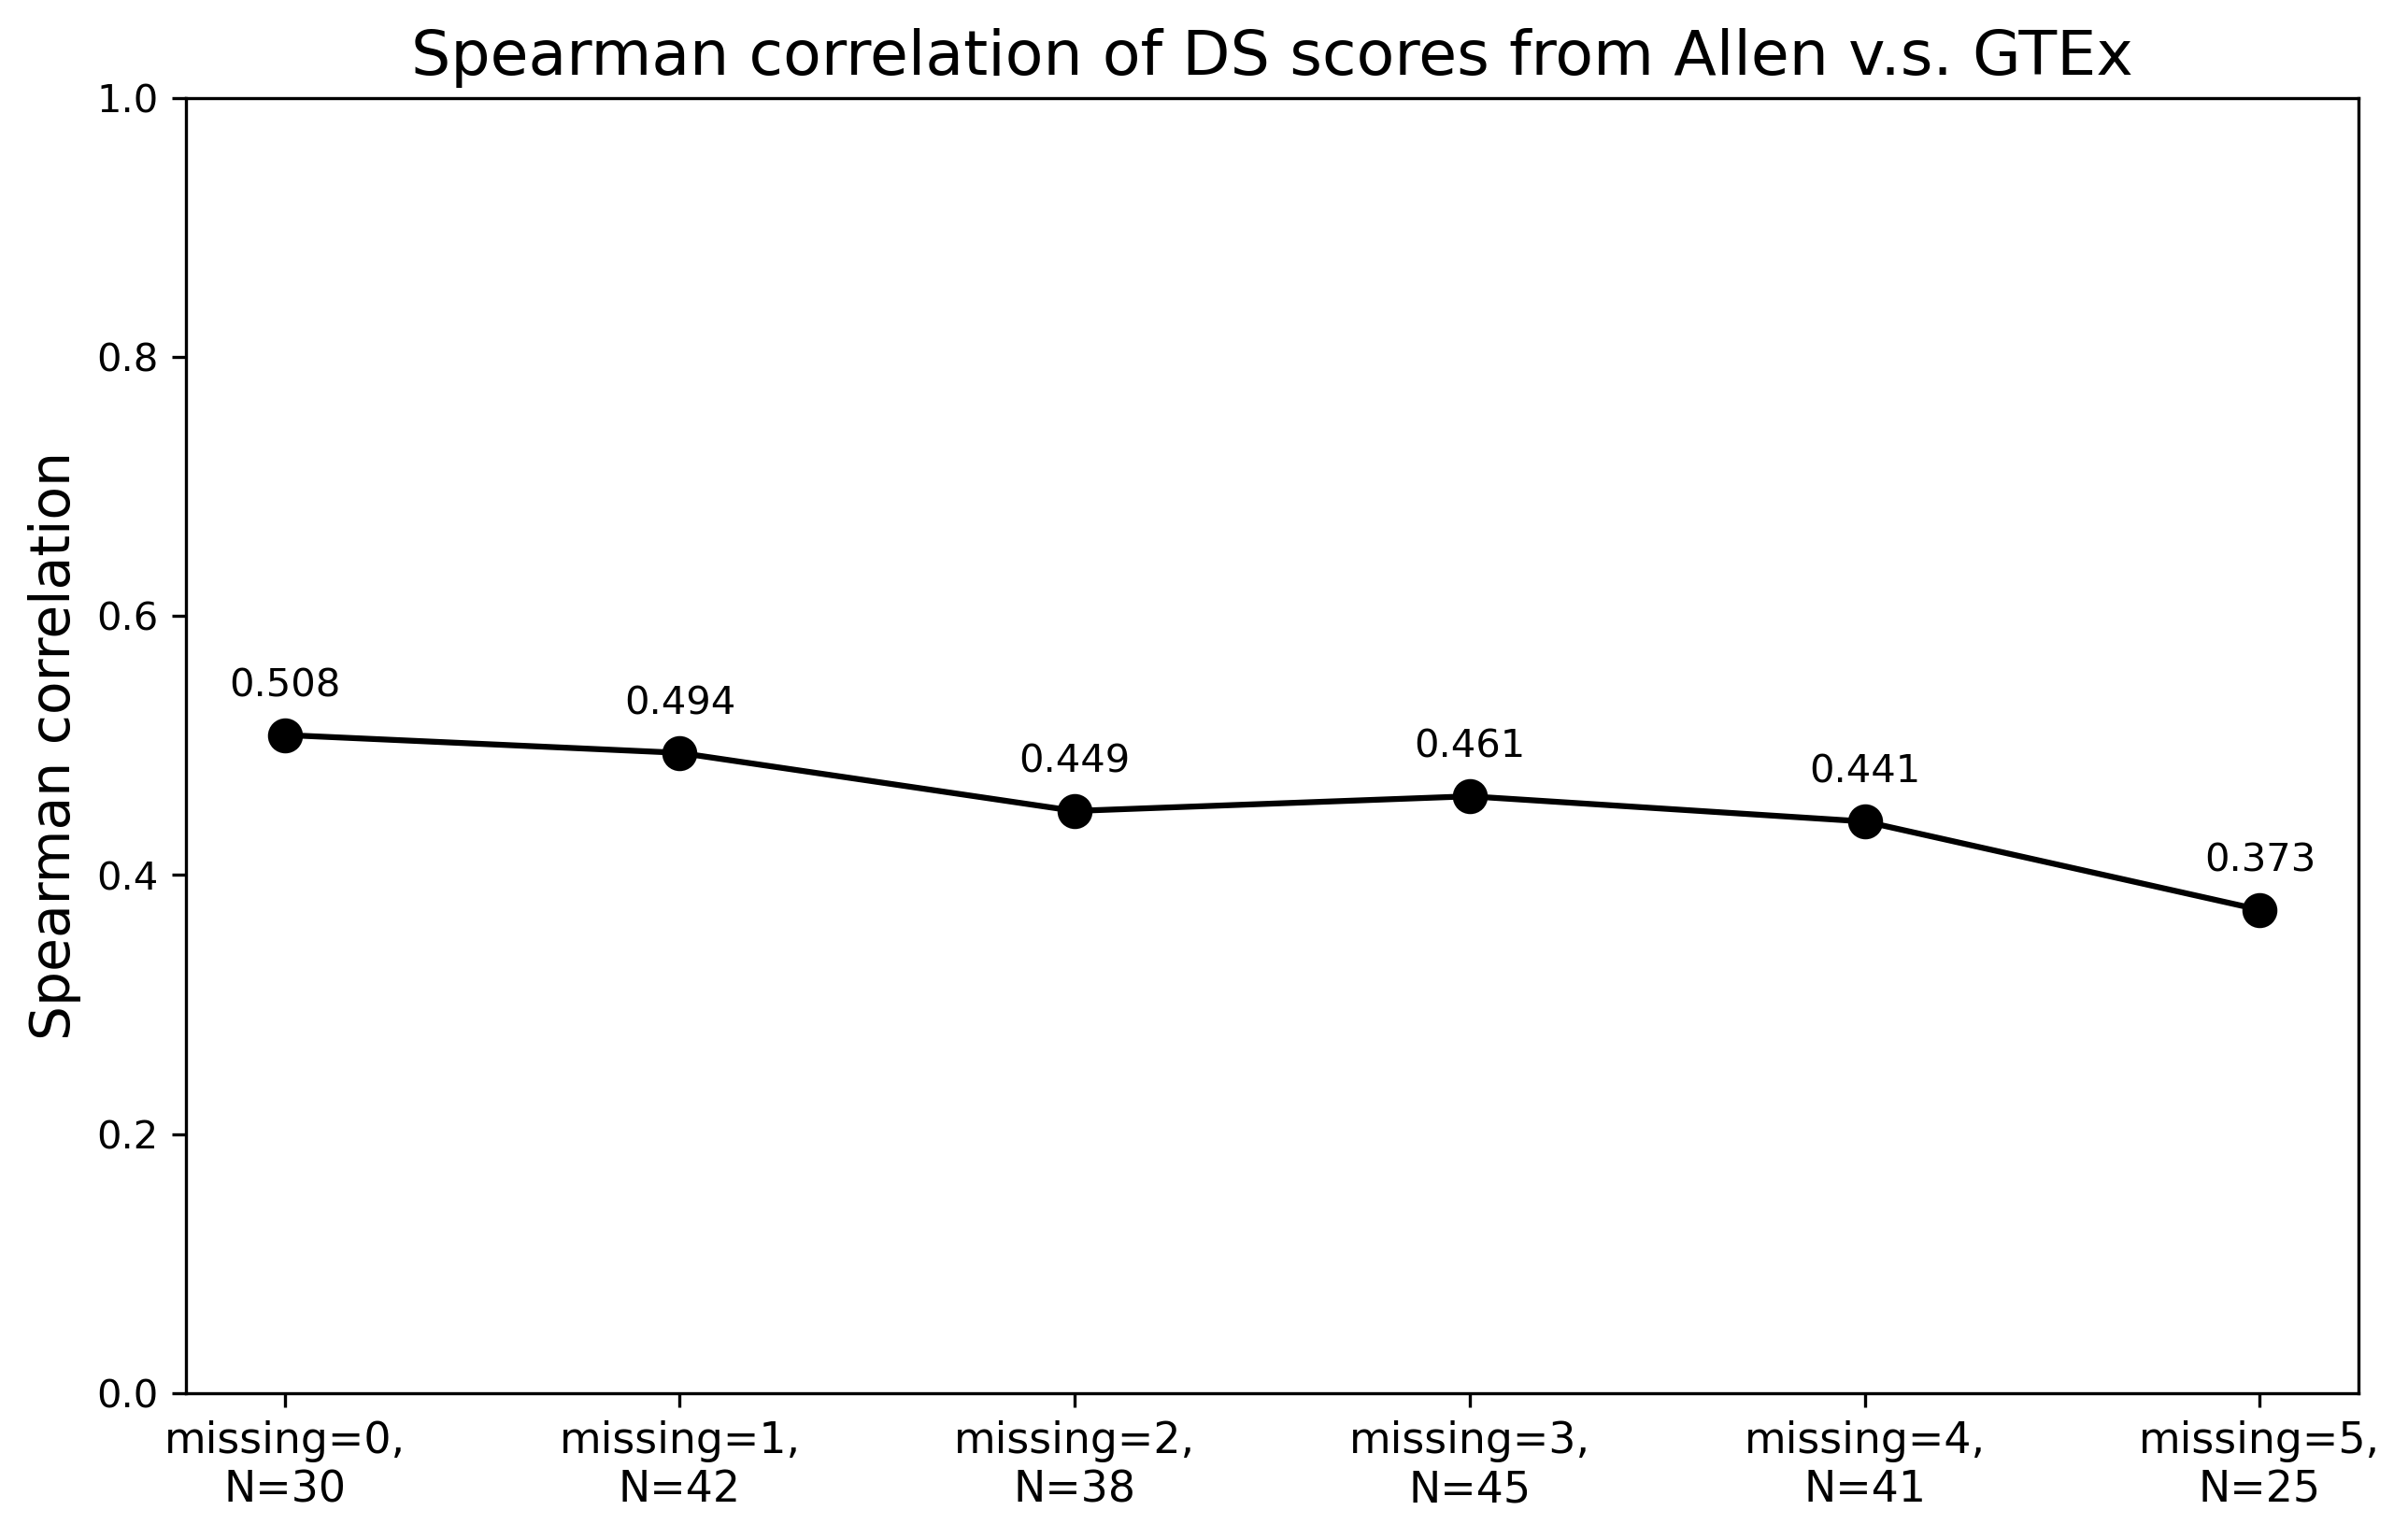

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6), dpi=300)
colors = ['black']  # Adjust colors as needed

# Loop through results to plot each model
for i, result in enumerate(results):
    spear_corr_list = result['spear_corr_list']
    n_subject_list = result['n_subject_list']
    
    # Plot the Spearman correlation curve for the current model
    plt.plot(
        range(N), 
        spear_corr_list, 
        marker='o', 
        color=colors[i % len(colors)],  # Cycle colors if needed
        linestyle='-', 
        markersize=8,
        label=result['model_name']
    )
    
    # Annotate each point with its value
    for j, value in enumerate(spear_corr_list):
        plt.text(
            j, 
            value + 0.03,  # Adjust the vertical position slightly above the dot
            f"{value:.3f}",  # Format the value to two decimal places
            ha='center', 
            fontsize=10
        )

# Set plot titles and labels
plt.title('Spearman correlation of DS scores from Allen v.s. GTEx', fontsize=16)
# plt.xlabel('N gtex subjects with the number of missing regions equals to X', fontsize=14)
plt.ylabel('Spearman correlation', fontsize=14)

# Customize x-ticks to include subject counts
x_labels = [f"missing={i},\nN={results[0]['n_subject_list'][i]}" for i in range(N)]
plt.xticks(range(N), x_labels, fontsize=11)

# Set y-axis limits and show the plot
plt.ylim(0, 1)
plt.show()


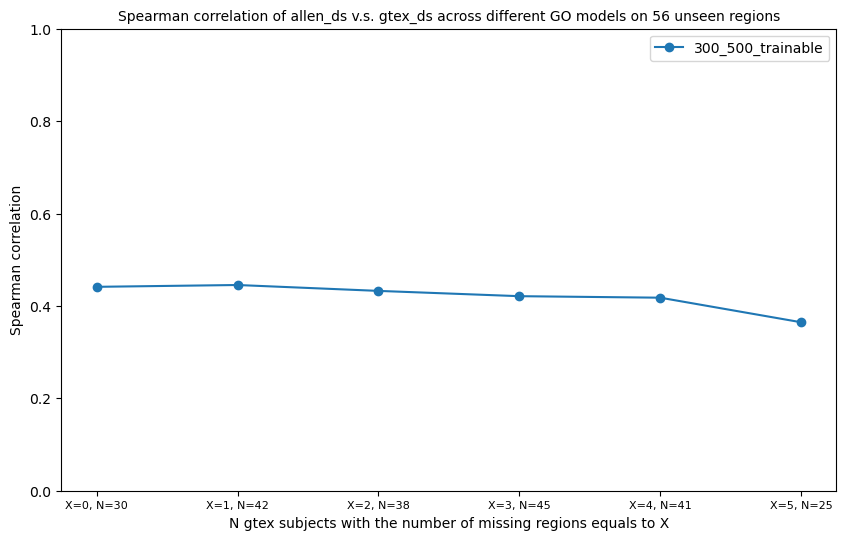

In [ ]:
allen_ds = ds_score_compute_56(allen_dict, all_ids)
N = 6
# Create violin plots
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
# for each model, plot a curve
for i in range(len(model_set)):
    spear_corr_list = []
    n_subject = []
    t_epoch, f_epoch, status = model_set[i]
    model_name = f"{t_epoch}_{f_epoch}_{status}"
    pred_exp_dict = go_prediction_dict[model_name]
    for missing_N in range(N):
        include_subjects = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()==(10-missing_N)]
        gtex_ds = ds_score_compute_56(pred_exp_dict, include_subjects)
        corr, p = spearmanr(allen_ds, gtex_ds)
        spear_corr_list.append(corr)
        n_subject.append(len(include_subjects))
    # plotting
    plt.plot([x for x in range(N)], spear_corr_list, marker='o', color=colors[i], linestyle='-', markersize=6, label=model_name)
    
# Plot means for second set of violin plots
plt.title(f'Spearman correlation of allen_ds v.s. gtex_ds across different GO models on 56 unseen regions', fontsize=10)
plt.xlabel('N gtex subjects with the number of missing regions equals to X', fontsize=10)
plt.ylabel('Spearman correlation', fontsize=10)
plt.xticks(range(N), [f"X={i}, N={n_subject[i]}" for i in range(N)], fontsize=8)
plt.ylim(0,1)
plt.legend()
plt.show()